In this notebook, we investigate three methods of altering data in an iterative way that will increasingly decrease the accuracy of a convolutional neural network.

Ideally run this in Google Colab with a GPU as this will make training the model considerably faster.

# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits
from keras.datasets import mnist
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

# Load and Inspect Data

The data we will be using is the MNIST data set compised of 	
70,000 hand-written digits. 
- There are 10 classes (numbers 0-9). 
- Each image is 28x28 pixels.
- There is only one channel as it is a greyscale image.
- The intensity is an integer between 0 and 255 so we need to normalise the pixels.

(Link: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

As we are going to train a model and test it, we can load the data into this split. X are the images and y are the labels that the model is trying to learn.

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [3]:
print('Train X', train_X.shape)
print('Train y', train_y.shape)
print('Test X', test_X.shape)
print('Test y', test_y.shape)

Train X (60000, 28, 28)
Train y (60000,)
Test X (10000, 28, 28)
Test y (10000,)


You can see we have a train-test split of 6:1.

We don't just want a train and test set. Instead, we want:
- a **train** set (to train the model on), 
- a **validation** set (to test the model on if we want to improve the generalizability) 
- a **test** set (that we can test the model on once it has been optimized).

So lets take the train set and split this up to form out train and validation sets.

In [4]:
val_X = train_X[40000:]
val_y = train_y[40000:]

train_X = train_X[:40000]
train_y = train_y[:40000]

In [5]:
print('Train X', train_X.shape)
print('Train y', train_y.shape)
print('')
print('Val   X', val_X.shape)
print('Val   y', val_y.shape)
print('')
print('Test  X', test_X.shape)
print('Test  y', test_y.shape)

Train X (40000, 28, 28)
Train y (40000,)

Val   X (20000, 28, 28)
Val   y (20000,)

Test  X (10000, 28, 28)
Test  y (10000,)


So now we have a 4:2:1 split.

The data contains images and image labels. Let's visualise the first 9 images with their labels.

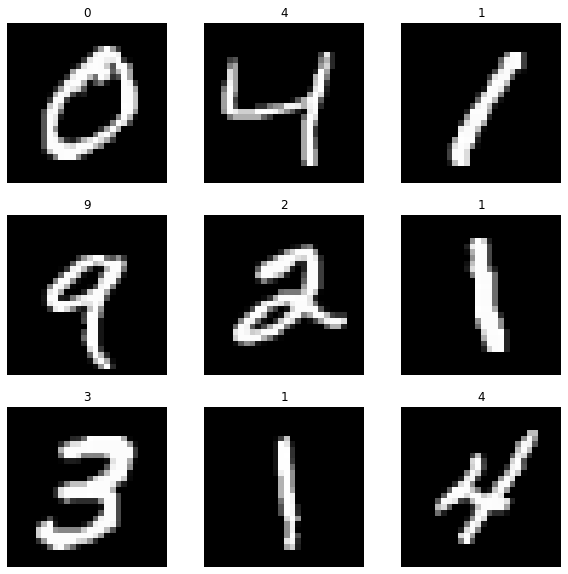

In [6]:
plt.figure(figsize = (10,10))
for i in range(1,10):

    plt.subplot(3,3,i)
    plt.gray()
    plt.imshow(train_X[i])
    plt.title(train_y[i])
    plt.axis('off')

plt.show() 

We need to reshape the data to be one list of images.

In [7]:
train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
val_X = val_X.reshape((val_X.shape[0], 28, 28, 1))
test_X_copy = test_X.copy().reshape((test_X.shape[0], 28, 28,1))

Make sure that the data is comprised of `float` values and then scale the data. We are doing this because these pixel values in the images are in the range 0-255 (black is 0, white is 1). However, we want them in the range 0-1 so that it contributes more evenly to the loss, making it easier for the model to learn. 

In [8]:
train_norm = train_X.astype('float32')
val_norm = val_X.astype('float32')
test_norm_copy = test_X_copy.astype('float32')

train_norm /= 255.0
val_norm /= 255.0
test_norm_copy /= 255.0

The output needs to be one hot encoded. For example:

0 is represented as  [1,0,0,0,0,0,0,0,0,0]

1 is represented as  [0,1,0,0,0,0,0,0,0,0]

2 is represented as  [0,0,2,0,0,0,0,0,0,0]

etc.

In [9]:
train_y = to_categorical(train_y)
val_y = to_categorical(val_y)
test_y = to_categorical(test_y)

# Create and Train a Model

Lets first define the model and the layers it contains. 
There will likely be another blog post specifically on these layers but for now, our model is a convolutional neural network (CNN).

In [10]:
model = models.Sequential()

model.add(layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu', padding = 'same', input_shape = (28,28,1)))
model.add(layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units = 10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

This is what our model looks like.

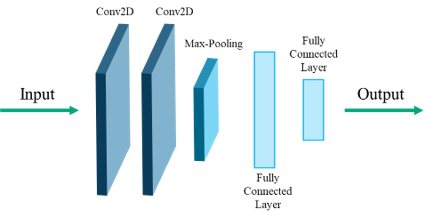

Define the loss and optimization (this is what helps the model learn and how fast to learn).

In [11]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

Train the model for 10 epochs. 1 epoch is when the model has assessed every image in the training data once.

In [12]:
history = model.fit(train_norm, train_y, batch_size = 128, validation_data=(val_norm, val_y), epochs=10)

Epoch 1/10
313/313 [==============================] - 37s 16ms/step - loss: 0.2913 - accuracy: 0.9097 - val_loss: 0.0756 - val_accuracy: 0.9783
Epoch 2/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0954 - accuracy: 0.9712 - val_loss: 0.0573 - val_accuracy: 0.9815
Epoch 3/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0709 - accuracy: 0.9779 - val_loss: 0.0490 - val_accuracy: 0.9852
Epoch 4/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0568 - accuracy: 0.9823 - val_loss: 0.0480 - val_accuracy: 0.9852
Epoch 5/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0494 - accuracy: 0.9838 - val_loss: 0.0410 - val_accuracy: 0.9874
Epoch 6/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0415 - accuracy: 0.9865 - val_loss: 0.0453 - val_accuracy: 0.9872
Epoch 7/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0350 - accuracy: 0.9884 - val_loss: 0.0475 - val_accuracy: 0.987

Let's see how the loss decreased and the accuracy increased over the course of training.

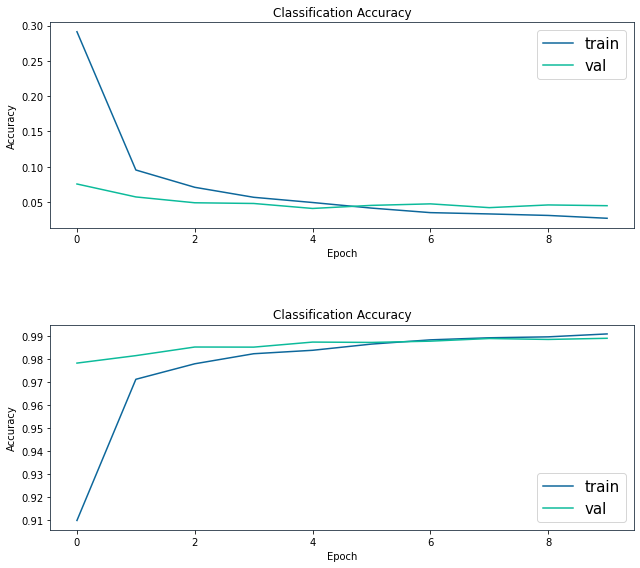

In [39]:
fig = plt.figure(figsize = (9, 8))
ax  = fig.add_subplot(2, 1, 1)
ax.plot(history.history['loss'], color='#0d679b', label='train')
ax.plot(history.history['val_loss'], color='#0CBB9B', label='val')
ax.spines['bottom'].set_color('#18293A')
ax.spines['top'].set_color('#18293A') 
ax.spines['right'].set_color('#18293A')
ax.spines['left'].set_color('#18293A')
ax.title.set_text('Classification Accuracy')
# ax.tick_params(axis = 'x', labelrotation = 45)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.legend(prop={'size': 15})

ax  = fig.add_subplot(2, 1, 2)
ax.plot(history.history['accuracy'], color='#0d679b', label='train')
ax.plot(history.history['val_accuracy'], color='#0CBB9B', label='val')
ax.spines['bottom'].set_color('#18293A')
ax.spines['top'].set_color('#18293A') 
ax.spines['right'].set_color('#18293A')
ax.spines['left'].set_color('#18293A')
ax.title.set_text('Classification Accuracy')
# ax.tick_params(axis = 'x', labelrotation = 45)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.legend(prop={'size': 15})
plt.tight_layout(h_pad=5.0)
plt.show()  

# How Noise Affects Accuracy

## Functions

This function takes an image, produces some noise that is the same shape as the image (28x28) and the perform an elementwise addition for all pixels whose sum is less than the maximum intensity (255).

In [40]:
def noisify_image( image , scale ):

  noise = np.random.normal(size = image.shape, 
                           loc = 0, 
                           scale = scale)
  
  new_image = np.zeros(image.shape)
  for i in range(new_image.shape[0]):
    for j in range(new_image.shape[1]):
      comb = image[i][j] + noise[i][j] 
      if comb <= 255:
        new_image[i][j] = comb
      else:
        new_image[i][j] = image[i][j] 

  return new_image

This function takes the dataset and creates a copy of it. It then adds normaly distributed random noise, with a specified standar deviation, to the images one at a time.

In [41]:
def noisify_prepare_data( image_set , scale ):

  noisy_test_X = image_set.copy()
  for i in tqdm(range(len(image_set))):
    noisy_test_X[i] = noisify_image(image_set[i], scale)

  noisy_test_X = noisy_test_X.reshape((image_set.shape[0], 28, 28, 1))
  noisy_test_norm = noisy_test_X.astype('float32')
  noisy_test_norm /= 255

  return noisy_test_norm

This function takes an image and the standard deviation for the normaly distributed random noise and then plots the original image, the noise, the combination of the two.

In [42]:
def show_noise(image, scale):

  if len(image.shape) == 3:
    image = image[:,:,0]    ## The image is size (28,28,1) but we only need the (28,28).

  noise = np.random.normal(size = image.shape, 
                           loc = 0, 
                           scale = scale)
  
  new_image = np.zeros(image.shape)
  for i in range(new_image.shape[0]):
    for j in range(new_image.shape[1]):
      comb = image[i][j] + noise[i][j] 
      if comb <= 255:
        new_image[i][j] = comb
      else:
        new_image[i][j] = image[i][j] 

  plt.figure(figsize = (15,5))

  plt.subplot(1,3,1)
  plt.imshow(image)
  plt.axis('off')
  plt.title('Image')

  plt.subplot(1,3,2)
  plt.imshow(noise)
  plt.axis('off')
  plt.title('Noise')

  plt.subplot(1,3,3)
  plt.imshow(new_image)
  plt.axis('off')
  plt.title('Noisy Image')
  plt.show()

## Visualise Different Scales of Noise

Let's first have a look at how different levels of noise affects the images.

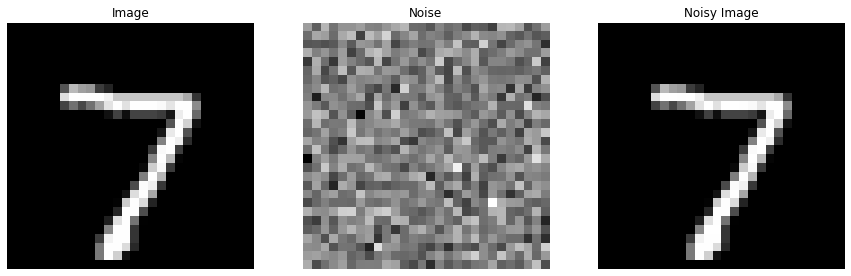

In [43]:
show_noise(test_X[0], 0.1)

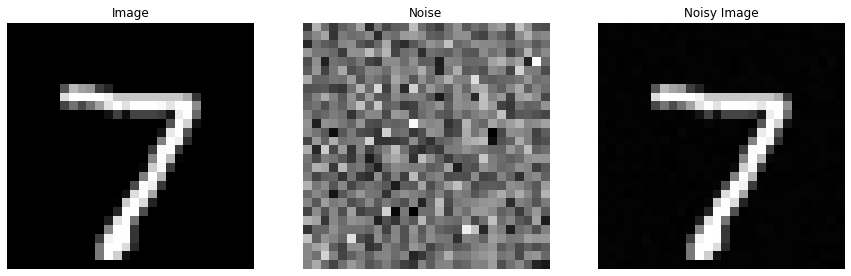

In [44]:
show_noise(test_X[0], 1)

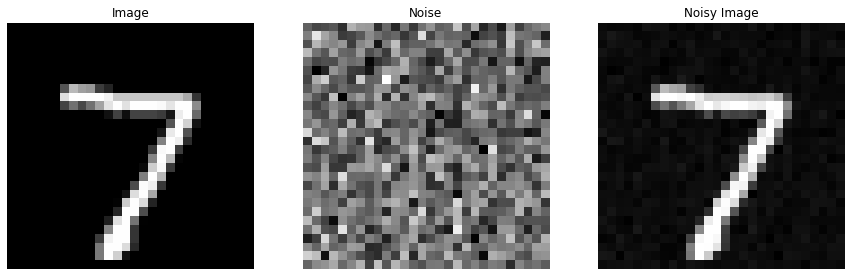

In [45]:
show_noise(test_X[0], 5)

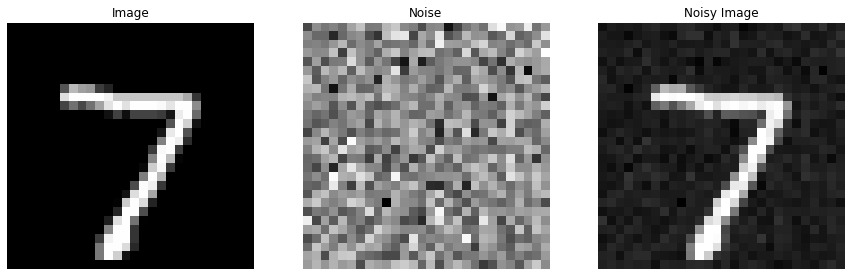

In [46]:
show_noise(test_X[0], 10)

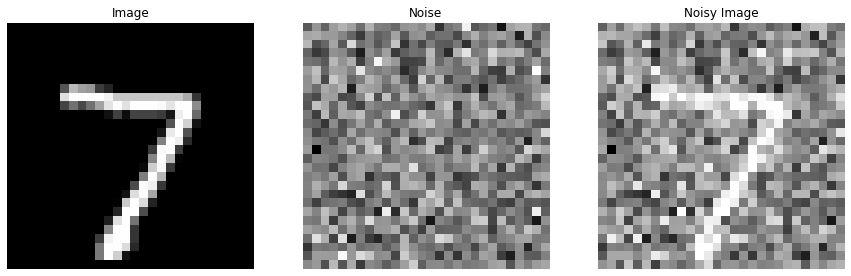

In [47]:
show_noise(test_X[0], 100)

Understandably, with a standard deviation of 100, it is possible as a human to make out the number 7 in this image but it could be difficult in others. For a model that has been trained on perfect data, we can expect it to have a low accuracy with this much noise.

Let's evaluate the model on the test set adjusted with these levels that we just visualised.

In [ ]:
noisy_test_01  = noisify_prepare_data( test_X_copy , 0.1)
noisy_test_1   = noisify_prepare_data( test_X_copy , 1 )
noisy_test_5   = noisify_prepare_data( test_X_copy , 5 )
noisy_test_10  = noisify_prepare_data( test_X_copy , 10 )
noisy_test_100 = noisify_prepare_data( test_X_copy , 100 )

100%|██████████| 10000/10000 [00:28<00:00, 350.45it/s]


In [ ]:
_, test_acc  = model.evaluate(test_norm_copy, test_y, verbose=0)

_, noise_acc_01  = model.evaluate(noisy_test_01, test_y, verbose=0)
_, noise_acc_1   = model.evaluate(noisy_test_1, test_y, verbose=0)
_, noise_acc_5   = model.evaluate(noisy_test_5, test_y, verbose=0)
_, noise_acc_10  = model.evaluate(noisy_test_10, test_y, verbose=0)
_, noise_acc_100 = model.evaluate(noisy_test_100, test_y, verbose=0)

print('Test Accuracy = {:.2f}%'.format(test_acc * 100.0))
print('Noisy Accuracy (std 0.1) =  {:.2f}%'.format(noise_acc_01 * 100.0))
print('Noisy Accuracy (std 1  ) =  {:.2f}%'.format(noise_acc_1 * 100.0))
print('Noisy Accuracy (std 5  ) =  {:.2f}%'.format(noise_acc_5 * 100.0))
print('Noisy Accuracy (std 10 ) =  {:.2f}%'.format(noise_acc_10 * 100.0))
print('Noisy Accuracy (std 100) =  {:.2f}%'.format(noise_acc_100 * 100.0))

Test Accuracy = 98.97%
Noisy Accuracy (std 0.1) =  98.98%
Noisy Accuracy (std 1  ) =  78.52%
Noisy Accuracy (std 5  ) =  37.18%
Noisy Accuracy (std 10 ) =  32.63%


## Evaluate the Model

Takes about 30 seconds to transform the whole dataset so lets just take half the dataset (500 images) instead. We will add noise with a range of standard deviations from 0 - 100. At every level we will record the model accuracy on the adjusted test set.

In [48]:
test_500 = test_X_copy[:500].copy()
test_500.shape

(500, 28, 28, 1)

In [49]:
accuracies = []
for i in range(100):
  noisy_data = noisify_prepare_data( test_500, i )
  _, acc = model.evaluate(noisy_data, test_y[:500], verbose = 0)
  accuracies.append(acc)

100%|██████████| 500/500 [00:01<00:00, 360.17it/s]


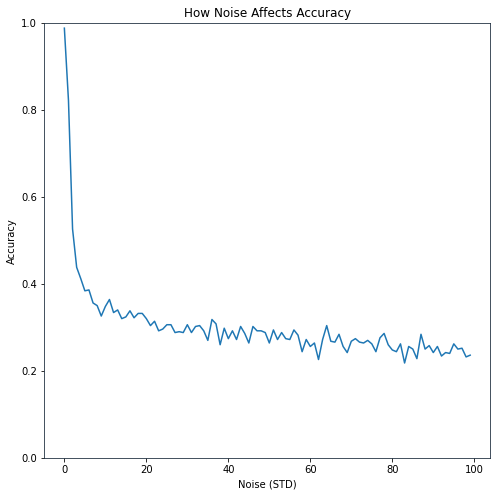

In [55]:
fig = plt.figure(figsize = (8, 8))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(range(100), accuracies)
ax.spines['bottom'].set_color('#18293A')
ax.spines['top'].set_color('#18293A') 
ax.spines['right'].set_color('#18293A')
ax.spines['left'].set_color('#18293A')
ax.title.set_text('How Noise Affects Accuracy')
# ax.tick_params(axis = 'x', labelrotation = 45)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Noise (STD)')
ax.set_ylim((0,1))
plt.show()  

The accuracy drops so quickly with only a slight addition of noise! This shows how delicate the model is to the training data.

Note that there are 10 classes, so an accuracy of 0.1 would be guessing with a random chance of being correct. So an accuracy of 0.2 is only slightly better than guessing at random. 

# How Adding White Boxes Affects Accuracy 

In this section we will add random white (pixel value = 255) boxes to the images and see how these will affect the accuracy.

## Functions

This function takes the image and box size that is an odd number. It will then select a random location that allows for the entire box to be added and then fills that part of the image with white pixels.

In [ ]:
def add_box( image, box_size ):

  side_px = int((box_size - 1) / 2)

  center_i = np.random.randint(low = side_px, 
                               high = image.shape[0] - side_px,
                               size = 1)[0]
  
  center_j = np.random.randint(low = side_px, 
                               high = image.shape[0] - side_px,
                               size = 1)[0]
  new_image = image.copy()
  for i in range(center_i - side_px, center_i + side_px + 1):
    for j in range(center_j - side_px, center_j + side_px +1 ):

      new_image[i][j] = 255
  
  return new_image

This function takes the entire dataset and adds square boxes with the side length of a specified number of pixels.

In [ ]:
def add_boxes( image_set , box_size ):
  image_set_boxes   = np.array([add_box(image, box_size) for image in image_set])
  image_set_boxes   = image_set_boxes.reshape((image_set_boxes.shape[0], 28, 28, 1))
  image_norm_boxes  = image_set_boxes.astype('float32')
  image_norm_boxes /= 255

  return image_norm_boxes

This function can be used to visualise the boxes on the image.

In [ ]:
def show_box( image , box_size ):

  box_image = add_box(image, box_size)

  plt.figure(figsize = (10,5))

  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.axis('off')
  plt.title('Image')

  plt.subplot(1,2,2)
  plt.imshow(box_image)
  plt.axis('off')
  plt.title(f'Image with a Box ({box_size} x {box_size})')

## Visualise Some Boxes

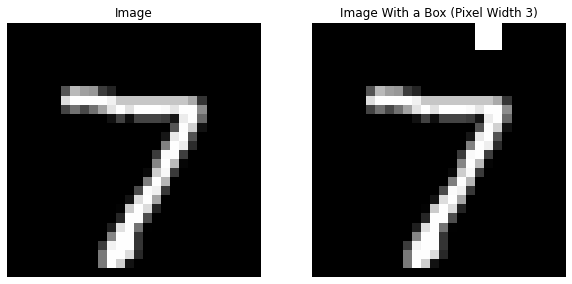

In [ ]:
show_box(test_X_copy[0][:,:,0], 3)

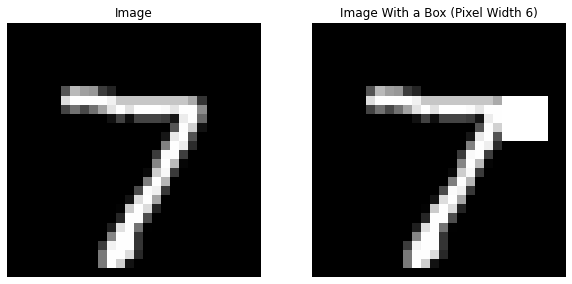

In [ ]:
show_box(test_X_copy[0][:,:,0], 6)

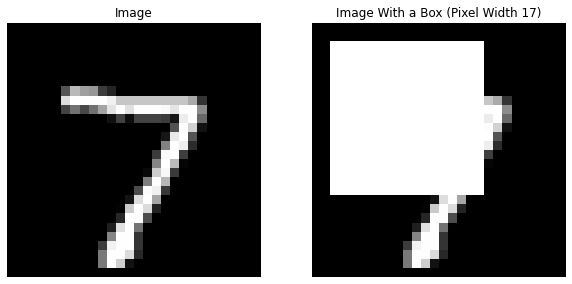

In [ ]:
show_box(test_X_copy[0][:,:,0], 17)

## Evaluate the Model

Let's evaluate the model on boxes with sizes ranging from 3x3 pixels to 27x27 pixels in increaments of 2 pixels per side (eg. 3x3, 5x5, 7x7, ..., 27x27).

In [ ]:
accuracies = []
for i in tqdm(range(3,29,2)):
  box_data = add_boxes(test_X_copy, i)
  _, acc = model.evaluate(box_data, test_y, verbose = 0)
  accuracies.append(acc)

100%|██████████| 13/13 [00:34<00:00,  2.67s/it]


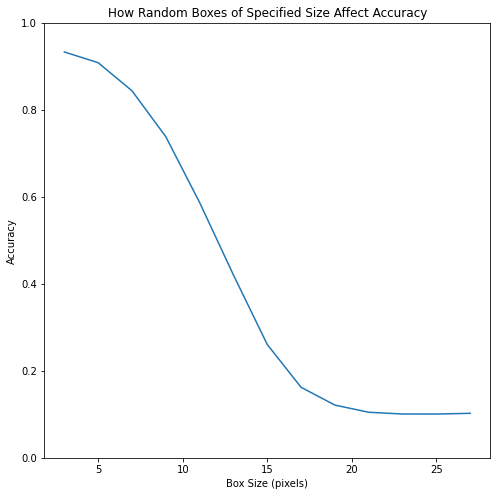

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(range(3,29,2), accuracies)
plt.title('How Random Boxes of Specified Size Affect Accuracy')
plt.xlabel('Box Size (pixels)')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.show()

It's no suprise that with a box covering 27x27 pixels in a 28x28 image, the model achieves an accuracy of random. You would get the same accuracy if you were just to call a random number generator.

# How Adding White Pixels Affects Accuracy

In this section we will just add a specified number of pixels to the images and see how these will affect the model accuracy.

## Functions

Here we copy the image and for the number of pixels specified we add white pixels at a random position. This function doesn't account for duplicated but there is a probability of 1 / (784 * number of pixels) of getting the same position twice as each position is independent of each other. So if you want to add 5 pixels, the probability of getting the same pixel twice is 0.000255. In a dataset size of 500, this is will not have a significant effect.

In [ ]:
def add_pixels( image , no_pixels ):
  new_image = image.copy()
  
  for _ in range(no_pixels):
    center_i = np.random.randint(low = 0, 
                                high = image.shape[0],
                                size = 1)[0]
  
    center_j = np.random.randint(low = 0, 
                                high = image.shape[0],
                                size = 1)[0]

    new_image[center_i, center_j] = 255
  
  return new_image

This function takes the above function and applies it to the entire data set and then performs the appropriate transformations to prepare for evaluation.

In [ ]:
def add_pixels_to_images( image_set , pixels ):
  image_set_pixels   = np.array([add_pixels(image, pixels) for image in image_set])
  image_set_pixels   = image_set_pixels.reshape((image_set_pixels.shape[0], 28, 28, 1))
  image_norm_pixels  = image_set_pixels.astype('float32')
  image_norm_pixels /= 255 

  return image_norm_pixels

This function just takes an image and shows how the output would look.

In [ ]:
def show_pixels( image , pixels ):

  pixel_image = add_pixels(image, pixels)

  plt.figure(figsize = (10,5))

  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.axis('off')
  plt.title('Image')

  plt.subplot(1,2,2)
  plt.imshow(pixel_image)
  plt.axis('off')
  plt.title(f'Image with {pixels} White Pixels')

## Visualise the Pixels

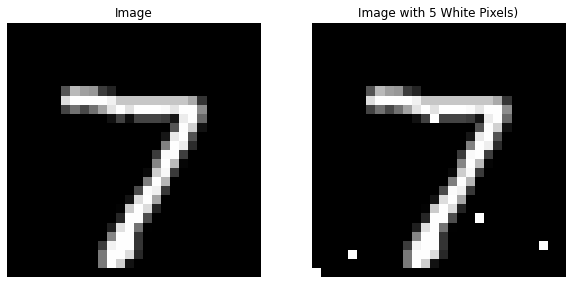

In [ ]:
show_pixels( test_X_copy[0][:,:,0], 5)

Here you can only notice 4 of the 5 pixels, likely because one of the pixels overlapped with the 7. 

## Evaluate the mModel

Here, we incrementally add pixels from 0 to the total number of pixels in image and evaluate the model on this dataset. This takes a while so just use 100 test images as 1000 would take too long but we will still see the trend with 100.

In [ ]:
accuracies = []
for i in tqdm(range(test_X_copy.shape[1] * test_X_copy.shape[2])):
  image_pixel_set = add_pixels_to_images(test_X_copy[:100], i)
  _, acc = model.evaluate(image_pixel_set, test_y[:100], verbose = 0)
  accuracies.append(acc)

100%|██████████| 784/784 [29:00<00:00,  2.22s/it]


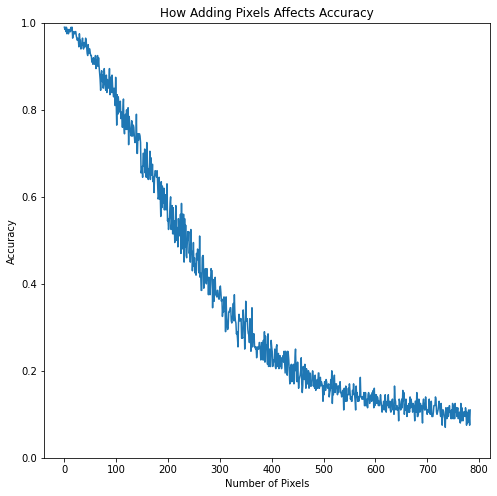

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(range(len(accuracies)), accuracies)
plt.title('How Adding Pixels Affects Accuracy')
plt.xlabel('Number of Pixels')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.show()

## Investigating the Results

To understand where this accuracy becomes more shallow we could look at the number of foregound pixels (those that are contained in the number) and compare that to the number of white pixels that we have added.

Rather than counting the foreground pixels, we will count the number of background pixels and take this away from the total number of pixels.

In [ ]:
def count_foreground( image ):

  unique, counts = np.unique(image, return_counts=True)
  count_dic = dict(zip(unique, counts))
  count_0 = count_dic[0]
  
  return (image.shape[0] * image.shape[1]) - count_0 

In [ ]:
def get_average_foreground( image_set ):
  counts = [count_foreground(image) for image in image_set]
  return sum(counts)/len(counts)

To compare to the above results, let's look at the same data.

In [ ]:
mean_fg_pixels = get_average_foreground(test_X_copy[:200])

In [ ]:
print(f'Mean number of foreground Pixels = {mean_fg_pixels}')

Mean number of foreground Pixels = 139.675


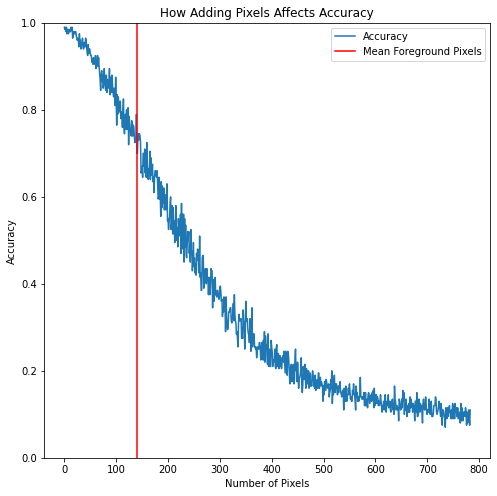

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(range(len(accuracies)), accuracies, label = 'Accuracy')
plt.plot([mean_fg_pixels]*2, [0,1], c = 'red', label = 'Mean Foreground Pixels')
plt.title('How Adding Pixels Affects Accuracy')
plt.xlabel('Number of Pixels')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.legend()
plt.show()

This is lower than I was expecting. My thought was that when we introduce as many white pixels as there are pixels making up the number in the image, the accuracy will begin to get signigicantly worse. However, this happens roughly around double this (~350), which also makes sense.

Let's see what these look like.

This is with the average number of foreground pixels.

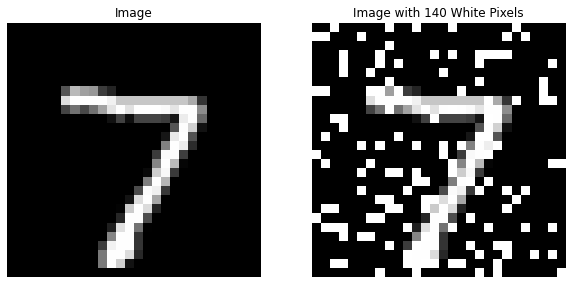

In [ ]:
show_pixels( test_X_copy[0][:,:,0], int(round(mean_fg_pixels)))

This is will double the average number of foreground pixels.

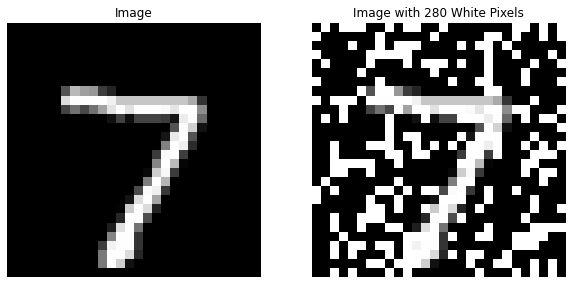

In [ ]:
show_pixels( test_X_copy[0][:,:,0], int(round(mean_fg_pixels)) * 2)

This is triple the average.

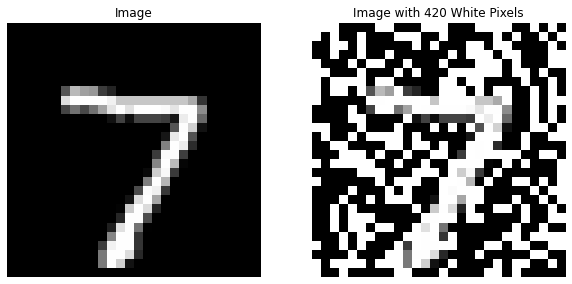

In [ ]:
show_pixels( test_X_copy[0][:,:,0], int(round(mean_fg_pixels)) * 3)

Visually we can see how much worse the second one (280 pixels) is to classify compared to 140 white-pixel image. However, in my opinion the 420 white-pixel image is not significantly worse than the 280 image. So we can understand why the model got drastically worse when adding up to 280 pixels and then only got gradually worse following this. 